### Using tf.data for Multiple Files

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
import numpy as np
import pickle
from tensorflow.keras import utils as np_utils

from sklearn.preprocessing import MinMaxScaler
# Load the TensorBoard notebook extension
#%load_ext tensorboard
# Clear any logs from previous runs

SHUFFLE_BUFFER = 500
BATCH_SIZE = 128

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.5.0
Eager execution: True


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x7f4f5730fbf8>

print(tf.test.gpu_device_name())
# /device:GPU:0

print(tf.config.get_visible_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x000001A4DBEC7040>
/device:GPU:0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df = pd.read_csv("edit_fixtures.csv",encoding='latin-1')

In [5]:
CATEGORIES = ['HOME', 'AWAY', 'DRAW'] # 0 = home, 0.5 = draw, 1 = away


In [6]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [7]:
df.head()

,fixture_id,home_id,h_elo,h_attack,h_defence,away_id,a_elo,a_attack,a_defence,result,h_Shots_on_Goal,h_Shots_off_Goal,h_Total_Shots,h_Blocked_Shots,h_Shots_insidebox,h_Shots_outsidebox,h_Fouls,h_Corner_Kicks,h_Ball_Possession,h_Goalkeeper_Saves,h_Total_passes,h_Passes_accurate,h_Passing_accuracy,a_Shots_on_Goal,a_Shots_off_Goal,a_Total_Shots,a_Blocked_Shots,a_Shots_insidebox,a_Shots_outsidebox,a_Fouls,a_Corner_Kicks,a_Ball_Possession,a_Goalkeeper_Saves,a_Total_passes,a_Passes_accurate,a_Passing_accuracy
0,65,33,1701.999982,1.465662,-0.509711,46,1499.785559,1.574221,-1.981735,0.0,3.0,4.2,10.6,3.4,6.2,4.4,8.2,4.6,55.6,2.4,568.0,488.0,83.4,5.2,4.0,11.6,2.4,8.0,3.6,10.4,4.2,52.0,2.0,405.0,306.6,75.6
1,66,34,1484.325864,1.080315,-0.996740,47,1735.523910,2.262229,-0.981297,1.0,4.0,5.6,13.2,3.6,7.2,6.0,9.8,3.2,46.6,1.4,430.4,322.8,72.6,5.8,4.2,14.6,4.6,8.4,6.2,8.6,5.2,64.2,2.8,577.2,481.8,83.4
2,67,35,1477.638408,1.309383,-1.821893,43,1484.035903,-0.045547,-0.167265,0.0,4.0,7.0,15.6,4.6,9.2,6.4,8.6,7.4,47.6,3.4,428.0,335.2,77.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68,36,1485.130306,-0.030110,-0.157769,52,1503.018276,1.689230,-1.204394,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4,4.6,11.8,3.8,6.6,5.2,11.0,4.6,48.0,3.6,390.2,294.2,75.4
4,69,37,1425.731483,0.373948,-1.192954,49,1644.610836,1.526170,-1.143879,1.0,2.4,6.8,14.6,5.4,8.8,5.8,9.8,7.2,56.2,2.2,481.8,374.8,76.4,3.0,4.0,10.6,3.6,6.8,4.0,10.6,3.0,51.0,2.8,531.8,444.4,83.0


In [ ]:
target = df.pop('result')

In [10]:
print(len(target))
target.value_counts()

14671


0.0    6490
1.0    4458
0.5    3723
Name: result, dtype: int64

In [ ]:
home = []
away = []
draw = []
for i in range(len(target)):
    if (target[i]==0.0):
        home.append(target[i])
    elif (target[i]==1.0):
        away.append(target[i])
    elif (target[i]==0.5):
        target[i]=2.0
        draw.append(target[i])
        
print(len(home))
print(len(away))
print(len(draw))
for i in range(len(draw)):
    print(draw[i])

In [12]:
tf.convert_to_tensor(df)

<tf.Tensor: shape=(14671, 35), dtype=float64, numpy=
array([[6.50000000e+01, 3.30000000e+01, 1.70199998e+03, ...,
        4.05000000e+02, 3.06600000e+02, 7.56000000e+01],
       [6.60000000e+01, 3.40000000e+01, 1.48432586e+03, ...,
        5.77200000e+02, 4.81800000e+02, 8.34000000e+01],
       [6.70000000e+01, 3.50000000e+01, 1.47763841e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.05681000e+05, 1.91000000e+02, 1.50786184e+03, ...,
        4.68800000e+02, 3.77800000e+02, 8.04000000e+01],
       [7.05682000e+05, 2.40000000e+02, 1.41787466e+03, ...,
        4.88000000e+02, 4.04600000e+02, 8.26000000e+01],
       [7.05683000e+05, 2.26000000e+02, 1.47748874e+03, ...,
        3.37600000e+02, 2.47000000e+02, 7.26000000e+01]])>

In [13]:
#normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
#normalizer.adapt(df)
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(df, target, test_size = 0.4, random_state=42)

In [16]:
print(len(x_train))
display(x_train)
print(y_val.value_counts())
print(x_train[0])

8802


array([[0.28603862, 0.15172956, 0.33742052, ..., 0.14825871, 0.11929432,
        0.31359649],
       [0.03371938, 0.14308176, 0.15648654, ..., 0.42114428, 0.35144217,
        0.80701754],
       [0.22323694, 0.03694969, 0.55563991, ..., 0.49975124, 0.44637356,
        0.87061404],
       ...,
       [0.03406943, 0.14858491, 0.27046949, ..., 0.        , 0.        ,
        0.        ],
       [0.00458889, 0.13207547, 0.57118172, ..., 0.47313433, 0.40352842,
        0.82675439],
       [0.13238891, 0.05424528, 0.27956703, ..., 0.54402985, 0.47941753,
        0.85745614]])

0.0    2571
1.0    1772
2.0    1526
Name: result, dtype: int64
[0.28603862 0.15172956 0.33742052 0.30437888 0.59254737 0.14544025
 0.16448657 0.0765556  0.56075911 0.29230769 0.30666667 0.36666667
 0.21666667 0.21904762 0.4        0.         0.56       0.63659794
 0.325      0.43456496 0.38032958 0.68913043 0.13114754 0.17142857
 0.18064516 0.13333333 0.17021277 0.14666667 0.         0.23076923
 0.26493506 0.08333333 0.14825871 0.11929432 0.31359649]


In [17]:
print(len(y_train))
print(y_train.value_counts())

8802
0.0    3919
1.0    2686
2.0    2197
Name: result, dtype: int64


In [18]:
print(len(x_val))
print(len(y_val))

5869
5869


In [19]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state=42)

In [ ]:
dummy_y = np_utils.to_categorical(y_train)

In [21]:
len(x_val)

2934

In [22]:
len(y_val)

2934

In [23]:
print(len(x_test))
print(len(y_test))

2935
2935


In [24]:
print(len(y_test))
y_test.value_counts()

2935


0.0    1284
1.0     884
2.0     767
Name: result, dtype: int64

In [25]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    
        print(i)
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(3, activation="softmax")) #hier sigmoid statt softmax aus tutprial da binary und anzahl Klassen anstatt 10
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy", # https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible
        metrics=["accuracy"],
    )
    return model


build_model(kt.HyperParameters())

0


In [26]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=200,
    executions_per_trial=3,
    overwrite=True,
    directory="edit_fixtures_no_players",
    project_name="helloworld",
)

0


In [27]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [37]:
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 200 Complete [00h 00m 37s]
val_accuracy: 0.5370370149612427

Best val_accuracy So Far: 0.5403317411740621
Total elapsed time: 02h 28m 45s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

Results summary
Results in edit_fixtures_no_players\helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')


In [29]:
hp = kt.HyperParameters()
learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
best_hps=tuner.get_best_hyperparameters(num_trials=1)
#print(best_hps)
best_model = tuner.get_best_models(num_models=1)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=best_model)
#tf.train.Checkpoint.restore(...).expect_partial()
#to_be_predicted = np.array([[[0.6579319133419915,1666.6615077675299,0.18500000000000003,-0.37750000000000006,0,6.795720454545455,0.4803987065096406,1653.0341501069572,0.18500000000000003,-0.6725000000000001,0,6.8410482]]])
#y_prob = best_model[0].predict(x_train)
#best_model[0].summary()


In [32]:
file_to_store = open("stored_object.pickle", "wb")
pickle.dump(tuner, file_to_store)

file_to_store.close()

In [30]:
file_to_read = open("stored_object.pickle", "rb")


loaded_tuner = pickle.load(file_to_read)


file_to_read.close()
print(loaded_tuner)

In [31]:
loaded_tuner.results_summary()

Results summary
Results in my_dir_raw\helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')


In [62]:
loaded_model = keras.models.load_model('best_model_edit_fixture')

In [63]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               9216      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6176      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1

In [51]:
loaded_model.layers[1].get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'tanh',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

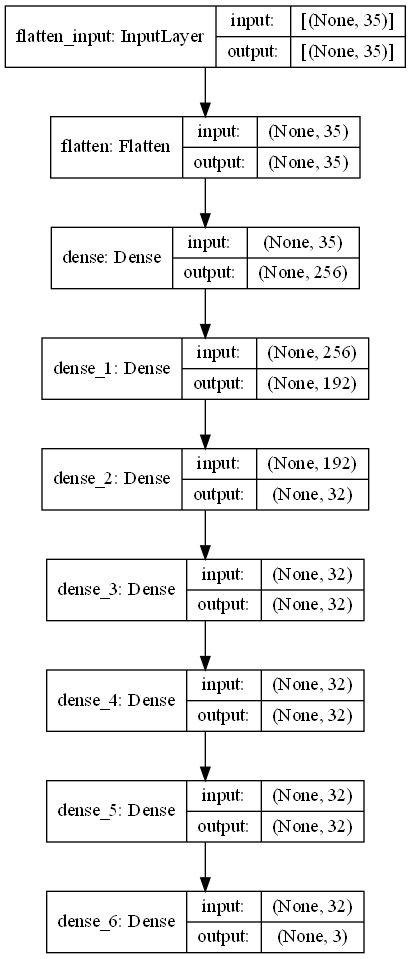

In [69]:
tf.keras.utils.plot_model(loaded_model, to_file="Bild_model.png", show_shapes=True)

In [59]:
loaded_model.layers[7].get_config()

{'name': 'dense_6',
 'trainable': True,
 'dtype': 'float32',
 'units': 3,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [56]:
loaded_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [ ]:
correct_prediction = 0
false_prediction = 0
y_true = []
y_pred = []
for i in range(len(x_test)):
   
    to_be_predicted = np.array([x_test[[i]]])
    y_prob = loaded_model.predict(to_be_predicted)
    
    result = y_test.iloc[[i][0]]
    predicted_result = np.argmax(y_prob) # wähle result mit
    #y_true.append(str(CATEGORIES[int(result)]))
    #y_pred.append(str(CATEGORIES[predicted_result]))
    y_true.append(result)
    y_pred.append(predicted_result)
    
    if(int(result) == predicted_result):
        print(f"Match {i}")
        print("result: " + str(CATEGORIES[int(result)]))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        correct_prediction = correct_prediction+1
    #print(y_prob[0][0])
    #print(y_prob[0][1])
    #print(y_prob[0][2])
    #print(f"result number {i}: " + str(y_val.iloc[[i][0]]))
    else:
        print(f"No Match: {i}")
        print("result: " + str(CATEGORIES[int(result)]))
    #print("prediction number "+ str(np.argmax(y_prob)))
        print("prediction: " + str(CATEGORIES[predicted_result]))
        false_prediction = false_prediction+1
print("correct: "+ str(correct_prediction) + "/" + str(len(x_test)))
print("correct: " +str(correct_prediction/len(x_test)))
print("false: "+ str(false_prediction) + "/" + str(len(x_test)))
print("false: " +str(false_prediction/len(x_test)))

In [38]:
classes=['HOME', 'AWAY', 'DRAW']

confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])



array([[1073,  206,    5],
       [ 427,  450,    7],
       [ 493,  230,   44]], dtype=int64)

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('tatsächliches Ergebnis')
    plt.xlabel('vorhergesagtes Ergebnis')
    plt.tight_layout()

Confusion matrix, without normalization
[[1073  206    5]
 [ 427  450    7]
 [ 493  230   44]]


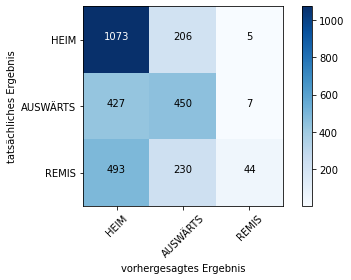

In [79]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0.0, 1.0, 2.0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['HEIM', 'AUSWÄRTS', 'REMIS'],
                      title='')

In [41]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [81]:
#Genauigkeit
print(ACC)

[0.61 0.7  0.75]


In [82]:
#Präzision
print(PPV)

[0.54 0.51 0.79]


In [83]:
#Trefferquote
print(TPR)

[0.84 0.51 0.06]


In [84]:
#F-Maß
F_SCORE= (2 * PPV * TPR)/(PPV+TPR)
print(F_SCORE)

[0.65 0.51 0.11]
